# Lecture 2: Forecasting and modeling

## Copyright
These notebooks, authored by Hussain Kazmi, are licensed under the AGPL License; you may not use this file except in compliance with the License. Notebooks are distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. Support from KU Leuven and InnoEnergy is gratefully acknowledged.

This lecture is focused on developing machine learning models and using them to create forecasts for the future. Being able to accurately predict the evolution of future energy supply and demand is extremely important in practice, both during the design phase and during the operational phase.

In [ ]:
# Install dependencies for this lecture
%pip install statsmodels==0.14.0 holidays==0.29 darts==0.24.0

### [Autocorrelations](https://en.wikipedia.org/wiki/Autocorrelation) and [partial autocorrelations](https://en.wikipedia.org/wiki/Partial_autocorrelation_function)

In this section, we look at how we can use autocorrelations and partial autocorrelations to better understand the periodicity in a time series using many different examples. The Autocorrelation is calculated by correlating the signal with a delayed copy of itself. Intuitively, this shows the similarity between observations as a function of the time lag between them, i.e. the periodicity in a time series. The partial autocorrelation, on the other hand, removes the effect of the interceding time steps. 

This section will be useful for figuring out if there is a historical component of the signal that can be used to forecast it in the future. This can specify an autoregressive (AR) model, a moving average (MA) model or a combination of the two (aptly named an ARMA model). AR models are the simplest to understand, as the output variable depends linearly on its own previous values and a random term.

Note that the [frequency spectrum](https://en.wikipedia.org/wiki/Frequency_domain) is an alternative way of understanding the periodicity in a time series. However, in this section we mostly focus on the autocorrelation and the partial autocorrelation of the signal.

As before, let's start by importing the necessary libraries and initializing the plots to be bigger and more legible.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
import holidays
from darts import TimeSeries
#from darts.models import NaiveSeasonal, Theta, RegressionModel, LightGBMModel
#from darts.metrics import mape, rmse, mae

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 22})

Instead of starting directly with a real world time series, we start with a really simple signal: a constant valued line. Think of this as a process that does not vary over time at all. Therefore, you would expect such a time series to not have any periodicity (or perfect periodicity, depending on how you look at these things).

In [2]:
constant_ts = np.ones(200)
constant_ts

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Next, we create a function to visualize this time series (which we can then call multiple times, by simply replacing the input time series). We use matplotlib to do this, which we introduced in the previous lecture. In case you have not defined or created functions in Python before, now is a good time to review this information.

In [3]:
def plot_ts(input_ts):
    plt.plot(input_ts)
    plt.xlabel('Time, $t$')
    plt.grid(True)
    plt.show()

Now, we can call this function with different time series, and it will create a plot for it. Let's do this for our constant time series.

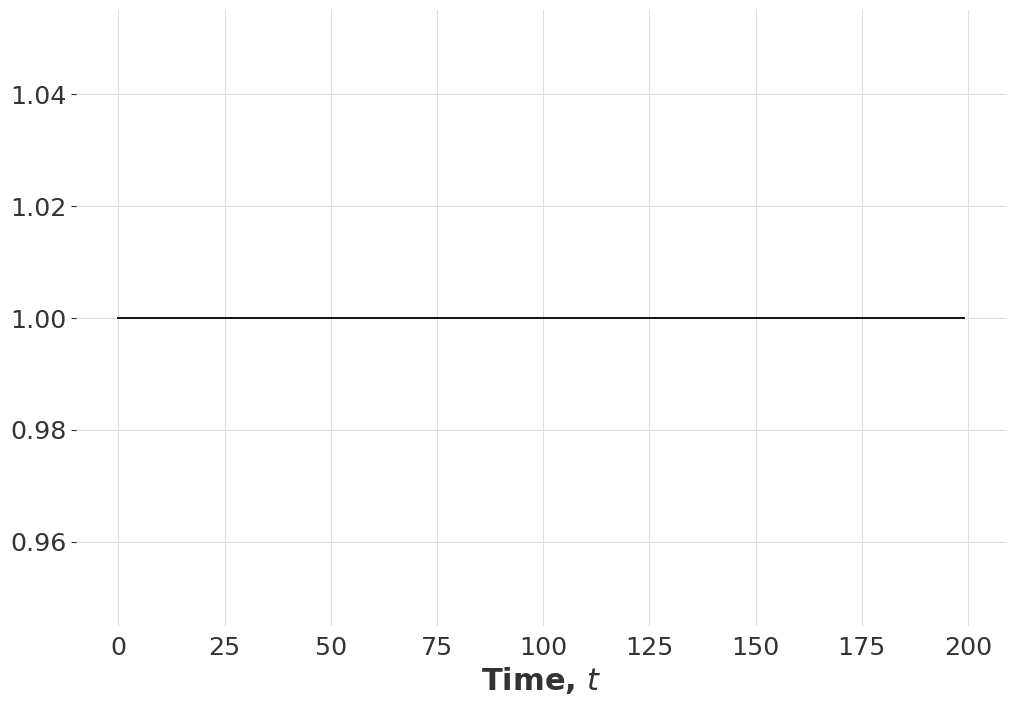

In [4]:
plot_ts(constant_ts)

So far, we have not seen anything really new. However, now we are in position to calculate the autocorrelation and cross-correlation of this signal. We can calculate the autocorrelation using the _correlate_ function from numpy. However, numpy has no inbuilt function for partial autocorrelation, so we will use the statsmodels library for this (using the _pacf_ function) later on in the lecture. 

Note that we are passing the numpy _correlate_ function with the same time series twice. This tells the function that it needs to calculate the autocorrelation function. If you input different time series, it will simply calculate the cross-correlation between them.

In [5]:
ACF = np.correlate(constant_ts, constant_ts, mode='full')

Now that we have the autocorrelation function, it is a good idea to also create a function which allows us to visualize it. We do this next. Note that we need to fix 

In [6]:
def plot_ACF(ACF):
    plt.plot(range(-int(len(ACF)/2), int(len(ACF)/2)+1), ACF)
    plt.xlabel('Autocorrelation lags')
    plt.ylabel('ACF')
    plt.grid(True)
    plt.show()

Finally, we can call this function to plot the autocorrelation function we just calculated for the constant time series.

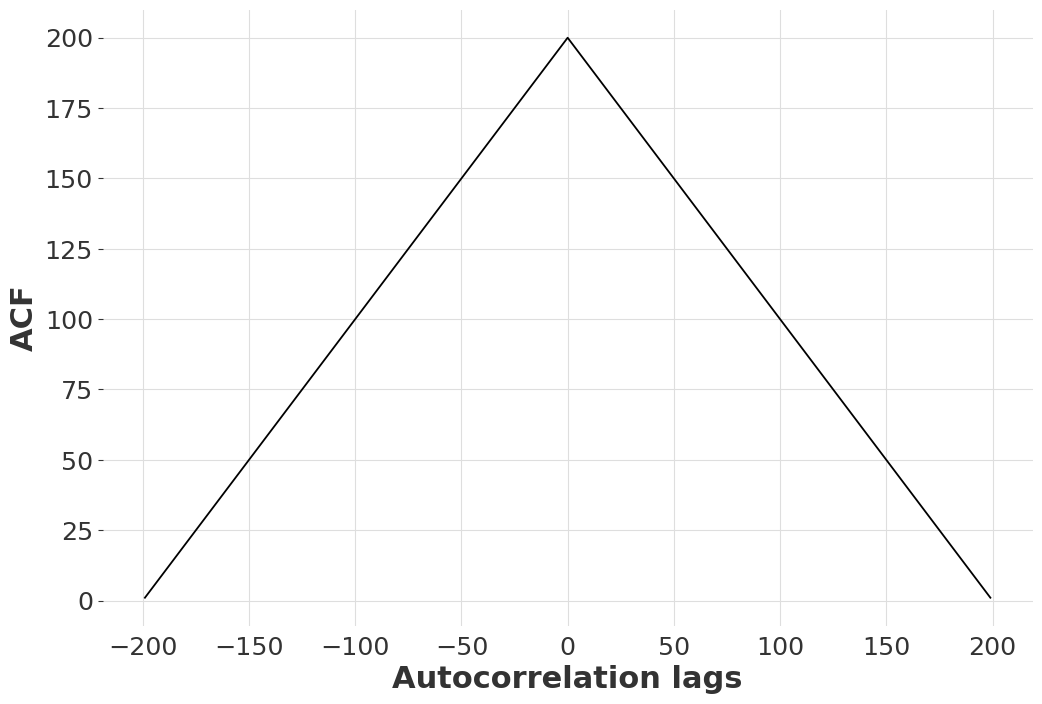

In [7]:
plot_ACF(ACF)

Some things should be immediately clear here. The autocorrelation has a symmetric output (i.e. on either side of the zero-th lag it looks exactly the same). Consequently, the signal's autocorrelation peaks at a lag of 0, i.e. when both signals have perfect overlap. As the overlap reduces, the autocorrelation value goes down. The monotonic decrease with no spikes indicates that there is no periodic component to the time series which is hardly surprising as the time series is a constant value.

What happens if instead of a constant time series, we take a linearly rising time series. While this series has a trend, it does not have any periodic component either, and therefore the autocorrelation should be a monotically decreasing function again. Let's verify this before moving on to more interesting time series.

Note that we use the _arange_ function from numpy to generate a monotonically increasing time series.

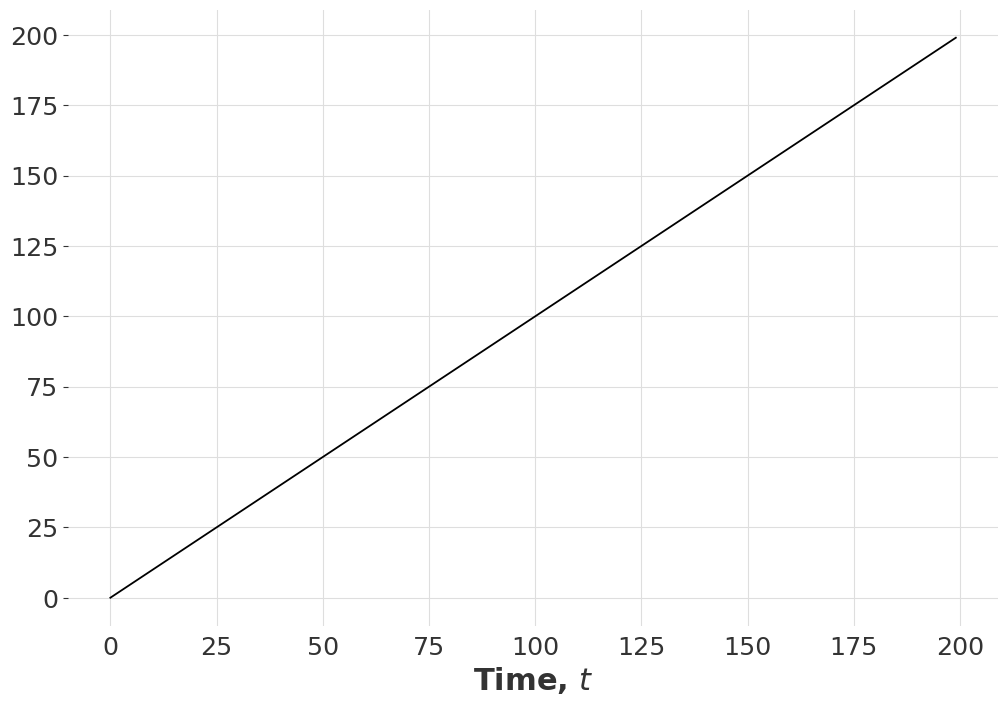

In [11]:
linear_ts = np.arange(200)
plot_ts(linear_ts)

And now, as before, we can use our _plot_ACF_ function to plot out the ACF of the linear_ts we have defined above.

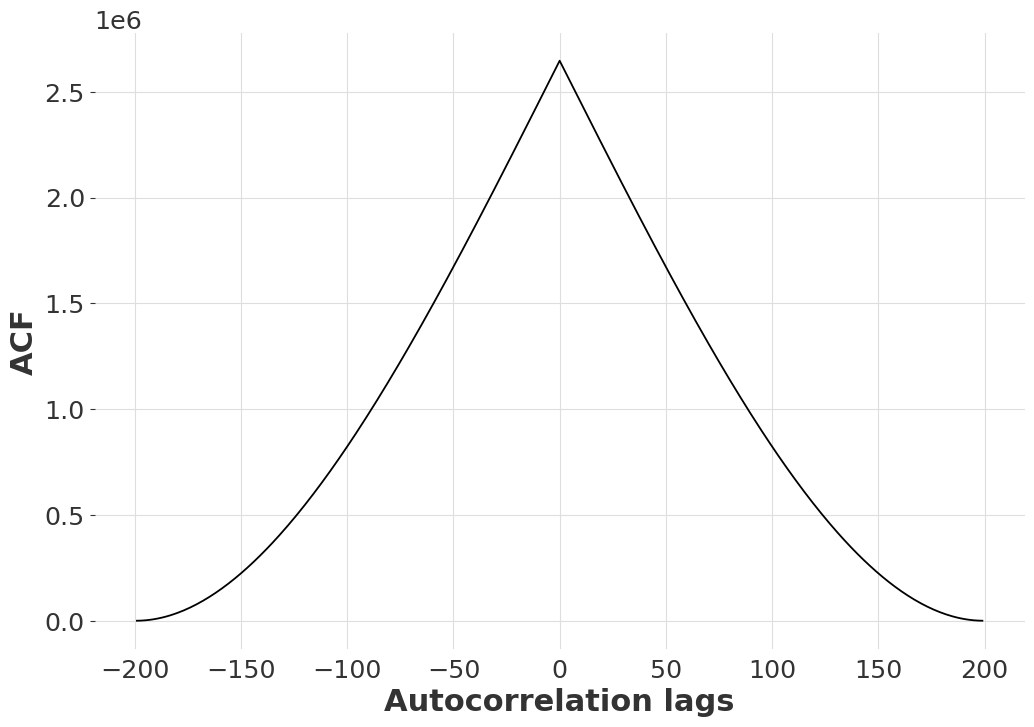

In [12]:
plot_ACF(np.correlate(linear_ts, linear_ts, mode='full'))

In [13]:
def entropy4(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  norm_counts = counts / counts.sum()
  base = 2 if base is None else base
  return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

labels = linear_ts
print (entropy4(labels))

7.6438561897747235


The shape of the ACF is a bit different than before, but the overall pattern remains the same which verifies our original hypothesis. Also note how we stacked multiple commands into a single line of code there. Calling a function and passing it the output of another function is fairly common practice in Python, which allows you to achieve a lot without writing lots of lines of code.

If you are interested in judging the predictive power of past values, then you need to instead calculate the partial autocorrelation of the function, which has a more sparse representation. We can use the _statsmodels_ library for this.


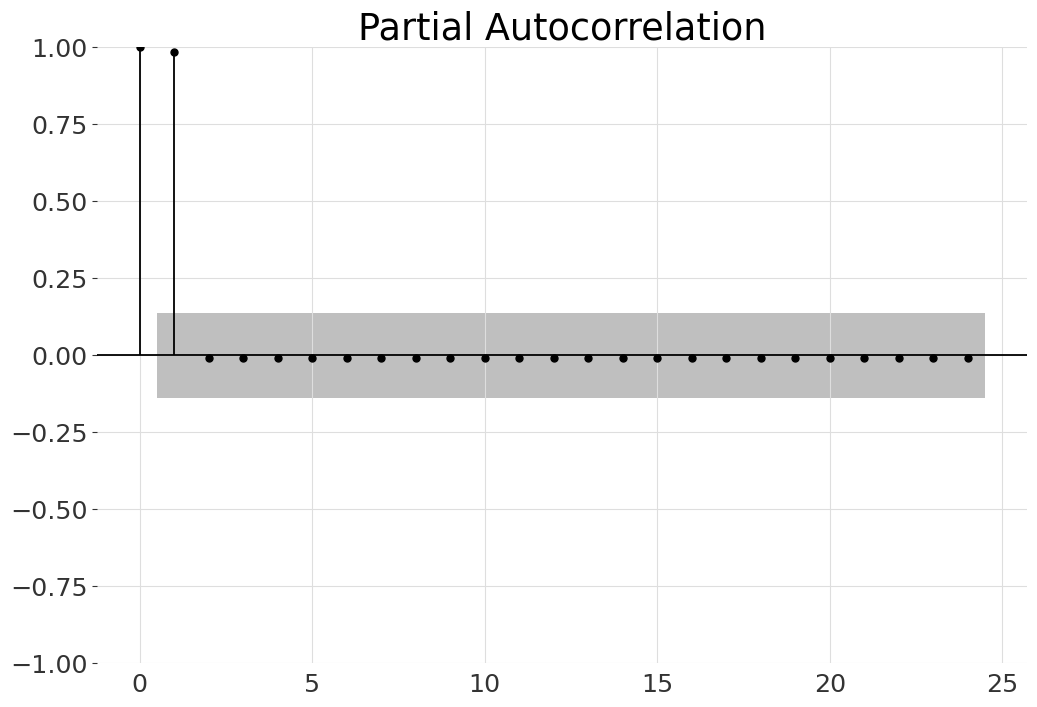

In [14]:
sm.graphics.tsa.plot_pacf(linear_ts)
plt.show()

The partial autocorrelation funciton (or PACF) clearly shows that the value of the time series with one lag describes the time series almost perfectly. This makes intuitive sense as we had created an artificial linearly rising time series. The concept is more general however. In time series analysis, PACF plots are often used to determine the order of the AR process, i.e. how many lags in the past need to be used to describe the future evolution of a time series. In this case, we have what we call an AR(1) process.

Note that you can also calculate the ACF using the _statsmodels_ library as well (which is also shown below).

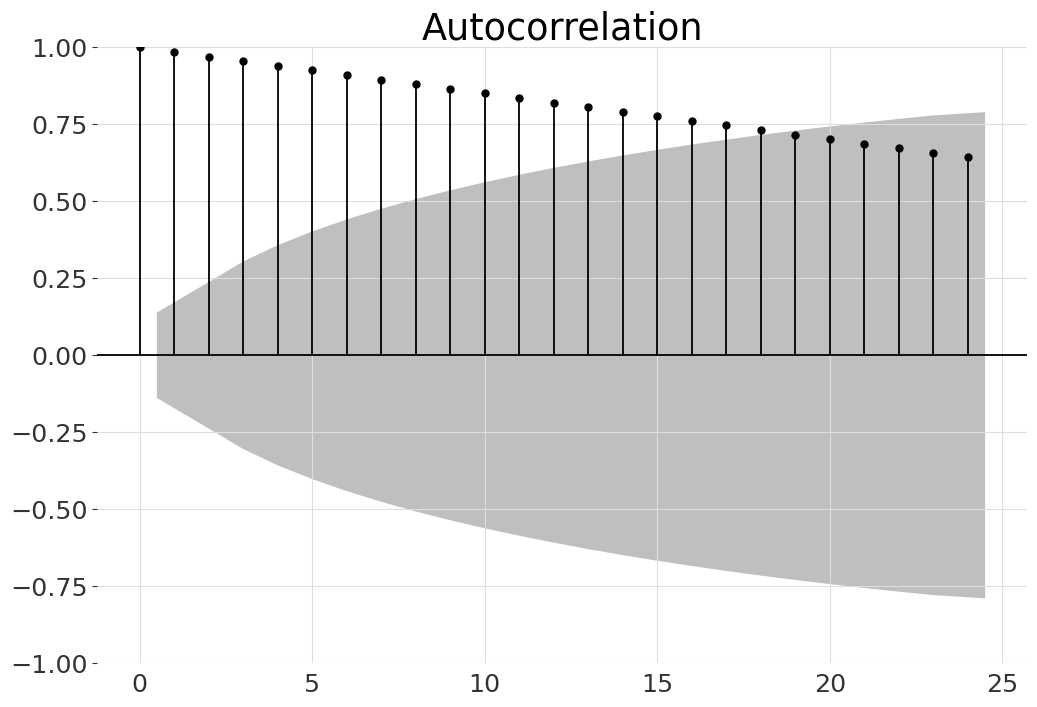

In [15]:
sm.graphics.tsa.plot_acf(np.arange(200))
plt.show()

Notice the difference between the ACF and the PACF? While the partial autocorrelation is extremely sparse (i.e. only one significant lag is present), the autocorrelation signal is much more spread out in terms of lags.

Furthermore, you will also notice that the ACF's calculated by numpy and statsmodels are quite different. There are a few reasons for this:
1. _statsmodels_ gets rid of one symmetric half of the ACF as it contains no new information; furthermore it also limits the amount of lags it shows which can be overridden using the _lags_ argument.
2. _statsmodels_ uses the correlation function of _numpy_ under the hood, but adds post-processing (mostly normalization) on top of it. This is done to ensure that the ACF makes sense from a statistical perspective.

Now, let's look at a more interesting signal as our time series: a simple sinusoid. This sinusoidal time series does not have a trend (i.e. its mean value remains the same over time), but there is a strong periodic component. Let's create and plot our sinusoidal signal first.

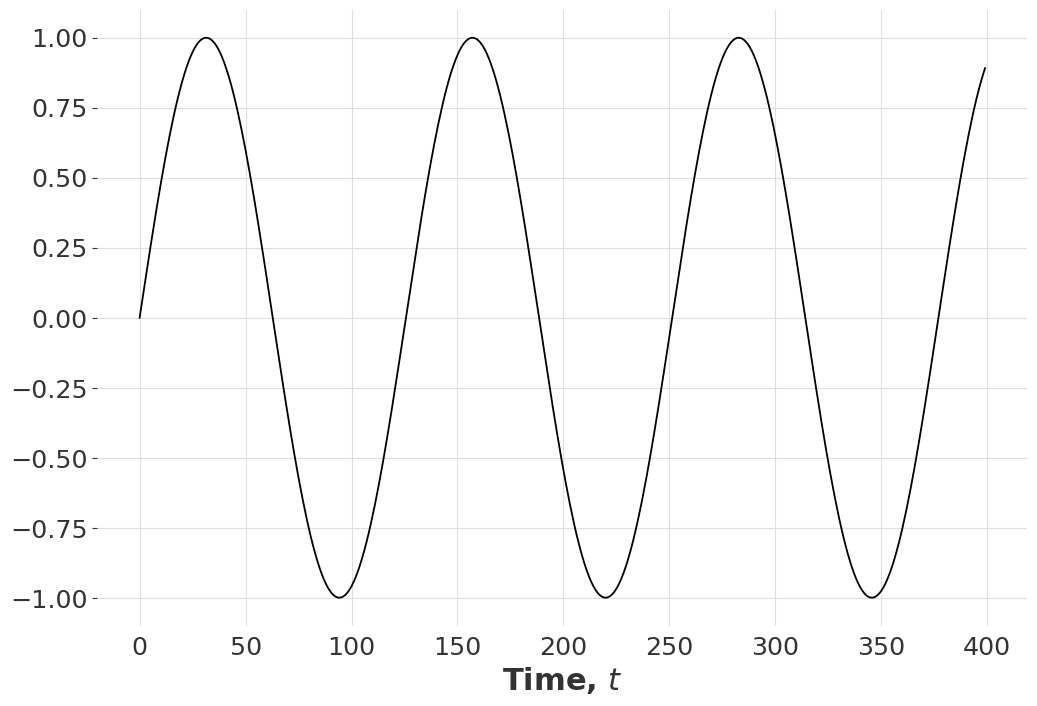

In [16]:
sin_ts = np.sin(np.arange(0, 20, .05))
plot_ts(sin_ts)

Now we can calculate the autocorrelation function of the sinusoid as before.

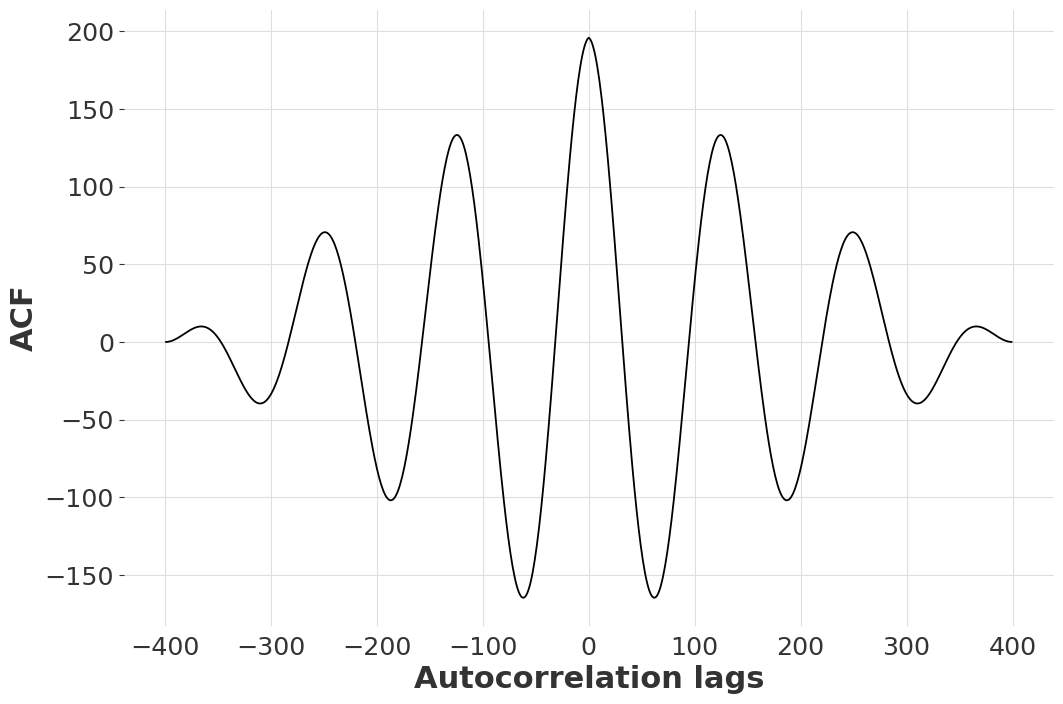

8.643856189774725


In [17]:
plot_ACF(np.correlate(sin_ts, sin_ts, mode='full'))
labels = sin_ts
print (entropy4(labels))

This looks more interesting than the ACF of linear or constant time series. The peaks in the autocorrelation represent potential periodicity in the data (the lags are typically counted from the center point). You can quickly verify this for the sinusoid. It is easy to see that the sinusoid repeats with a period of about 125 time steps. The peaks at around the 125th lag in the ACF plot reflect this.


This information about the periodicity in the signal can be used as a rough first measure of which points can be used to predict the future. For time series where the partial autocorrelation function coefficients do not drop off quickly (as in the case of a sinusoid), the data might exhibit nonlinear phenomena. One way to deal with is to difference the data and analyze the differenced data for correlations.

In reality, we will usually encounter signals which are much, much more complex than pure sinusoidal waves. A mixture of sinusoids of different frequencies is a step in this direction. Such a time series is a good approximation of time series which exhibit periodicity on multiple time scales, such as solar energy production in buildings (where there is a diurnal and annual periodicity) as well as energy demand in buildings (where we have diurnal, weekly and annual periodicity).


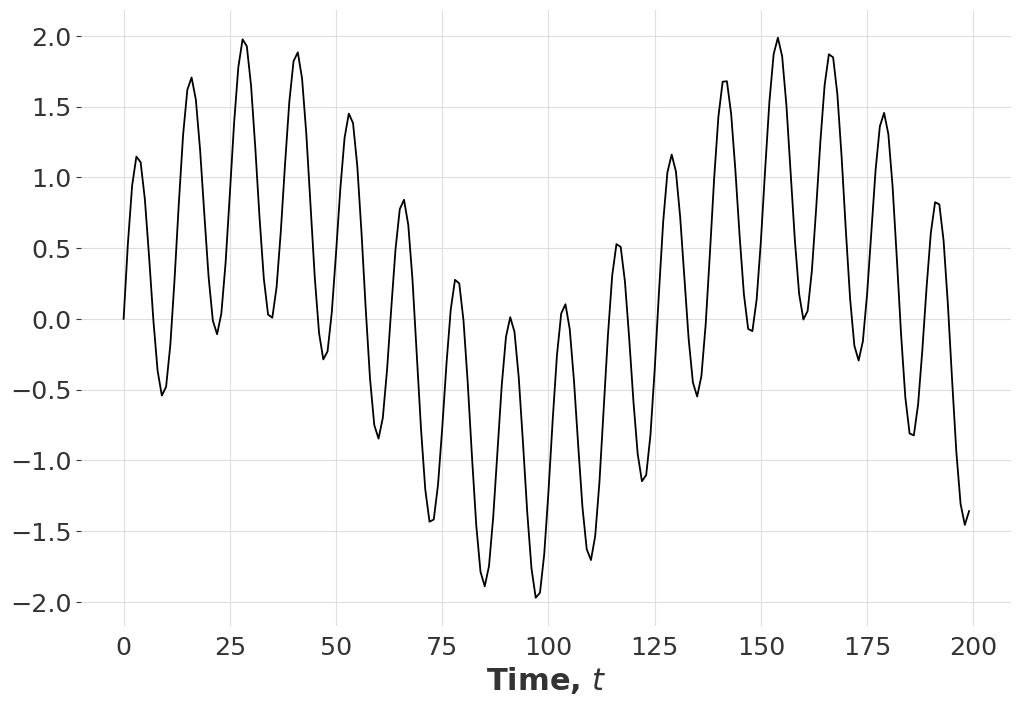

In [18]:
mixed_ts = np.sin(np.arange(0, 10, .05)) + np.sin(np.arange(0, 100, .5))
plot_ts(mixed_ts)

Now, we can calculate the ACF of the mixture of sinusoids as before. What we expect is to see the two different periodicities in the ACF clearly.

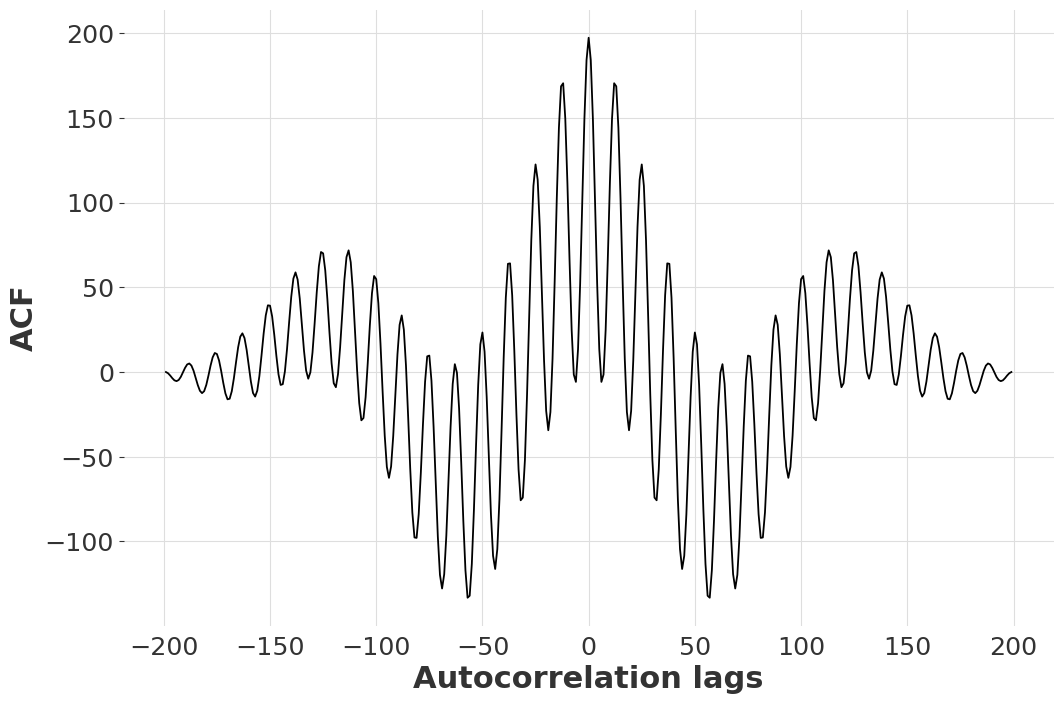

In [19]:
ACF = np.correlate(mixed_ts, mixed_ts, mode='full')
plot_ACF(ACF)

And there you have it! Using the ACF, you can clearly see that there are at least two timescales at which there is periodicity in the signal (as before, you can verify these by counting the lags at which you have peaks in your autocorrelation time series).

In addition to being composed of different frequencies (manifesting as different periodicities in the data), time series are also corrupted by different types of noise. There can be many sources and types of noise in our observations. However, in practice this noise is often modelled according to the [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution). We can analyze such a noise time series itself to see how its autocorrelation would look like in practice.

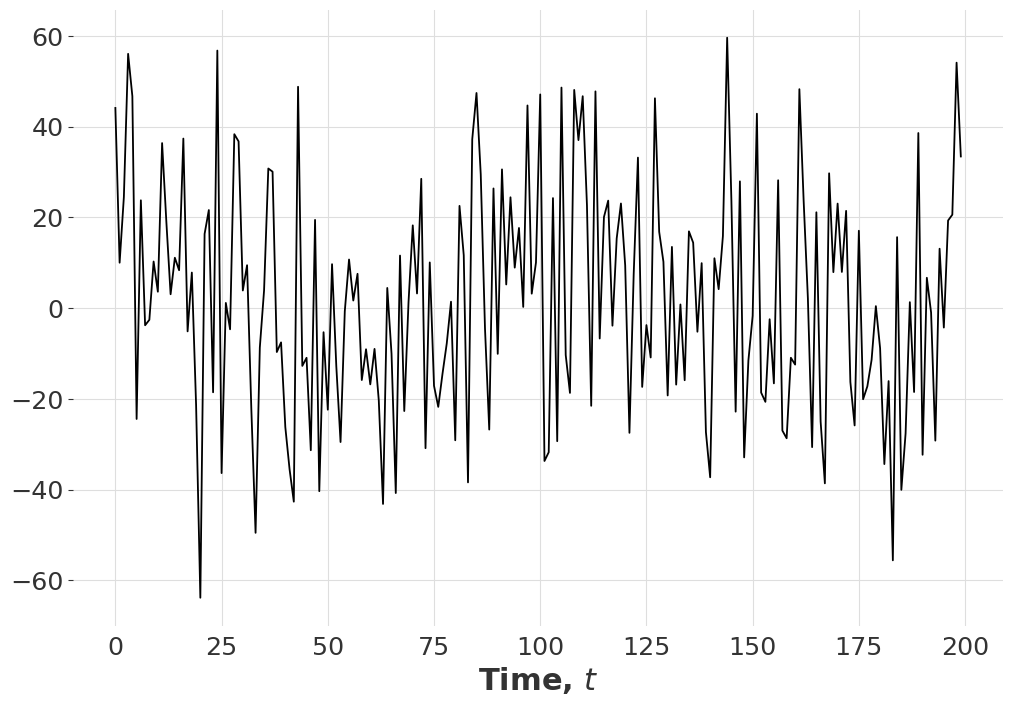

In [20]:
np.random.seed(0)
noise_ts = np.random.normal(0, 25, 200)
plot_ts(noise_ts)

As you would expect, Gaussian noise does not seem to have a discernible trend or periodicity to it. The random seed setter is meant to ensure reproducibility. Try the code with the same seed value for multiple runs and then change it to a different value to see this in action. Next, we calculate the ACF of this noise time series, even though we do not expect to see a strong autocorrelation peak anywhere.

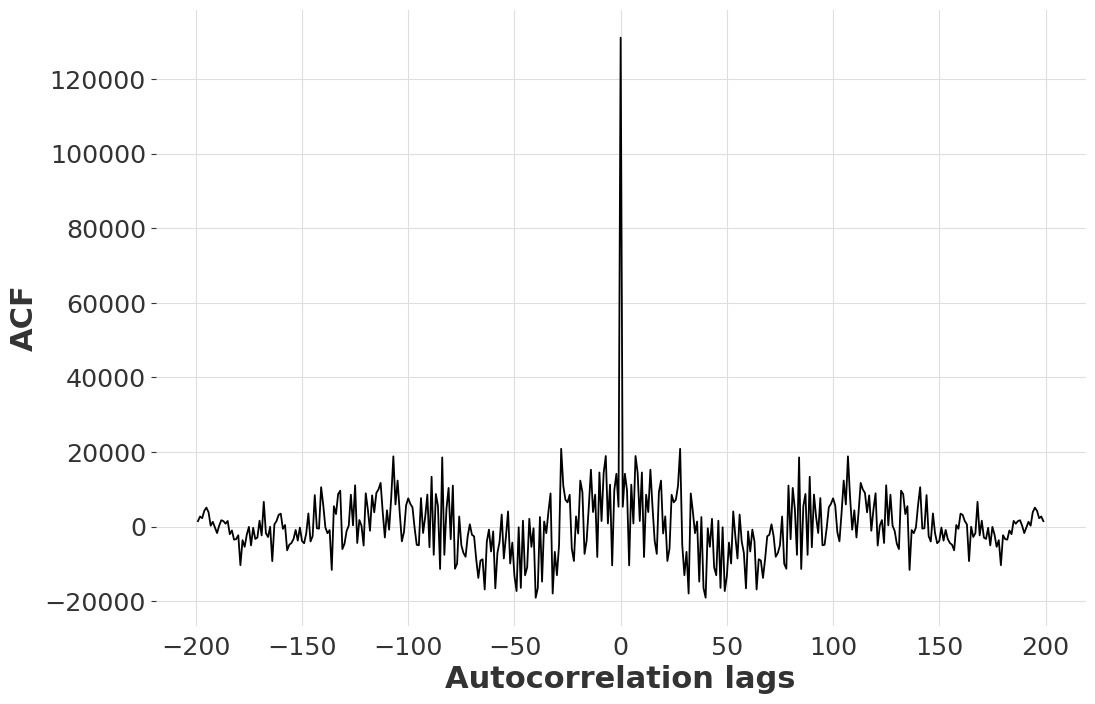

7.6438561897747235


In [21]:
plot_ACF(np.correlate(noise_ts, noise_ts, mode='full'))
labels = noise_ts
print (entropy4(labels))

As expected the autocorrelation of a noise signal is high only at the $0^{th}$ lag. Everywhere else it is close to 0. Theoretically, it should be 0 at these places, but some spurious correlations exist because of the finite duration of the time series. 

### Autocorrelation playground

In [22]:
def plot_autocorrelation(signal, lag):
    original_signal = pd.Series(signal)
    shifted_signal = original_signal.copy()
    shifted_signal.index -= lag

    ACF = np.correlate(signal, signal, mode="full")
    ACF_index = range(-int(len(ACF) / 2), int(len(ACF) / 2) + 1)

    fig, axs = plt.subplots(2, 1)
    ax0, ax1 = axs
    ax0.plot(signal, label="original", alpha=0.5)
    ax0.plot(shifted_signal, label="shifted", alpha=0.5)
    ax0.set_xlabel('Time')
    ax0.set_ylabel('Signal')
    ax0.grid(True)
    ax0.legend()

    ax1.plot(ACF_index, ACF)
    ax1.plot([lag], [ACF[ACF_index.index(lag)]], 'ro')
    ax1.set_xlabel('Autocorrelation lags')
    ax1.set_ylabel('ACF')
    ax1.grid(True)
    plt.show()

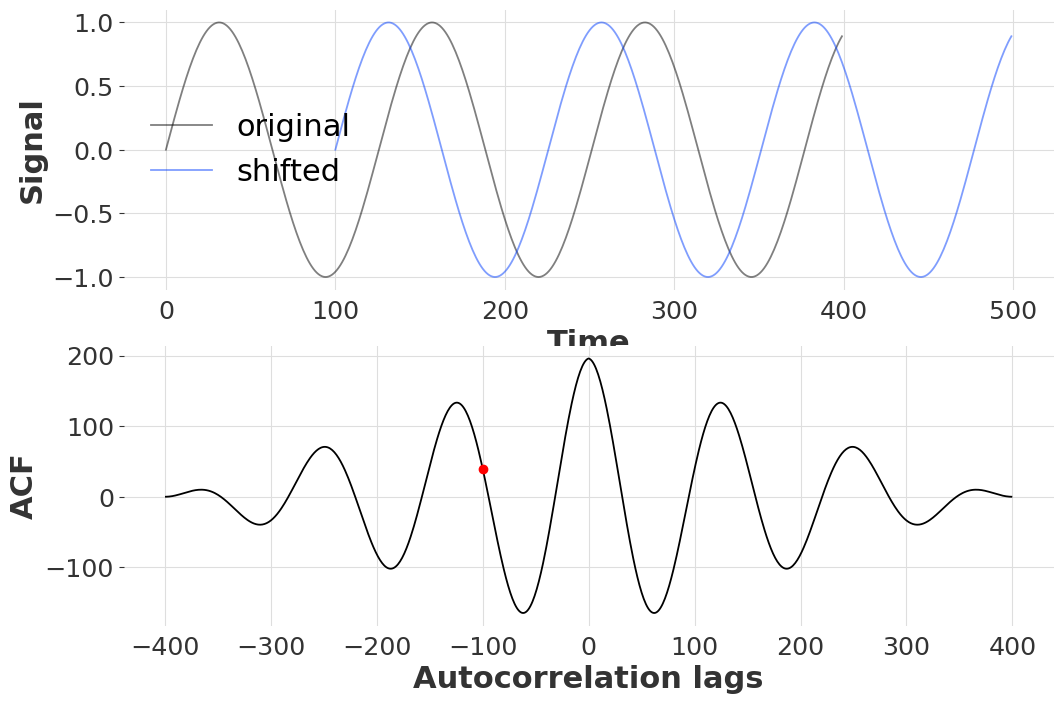

In [23]:
plot_autocorrelation(sin_ts, -100)

### Decomposition analysis



A more intuitive view of time series analysis includes decomposing a time series into its constituents: a trend component, seasonality and noise. Sometimes, a cyclical component is added as well. However, there is no single way that these components can be estimated and a large variety of algorithms have been proposed for time series decomposition (although most involve some form of filtering and/or curve fitting). 

In this lecture, we begin with using the statsmodels library to estimate the time series components. First, let's import the necessary libraries. To run the seasonal decomposition, we use a new synthetic signal. This one is a combination of a periodic sinusoid and a linear trend.

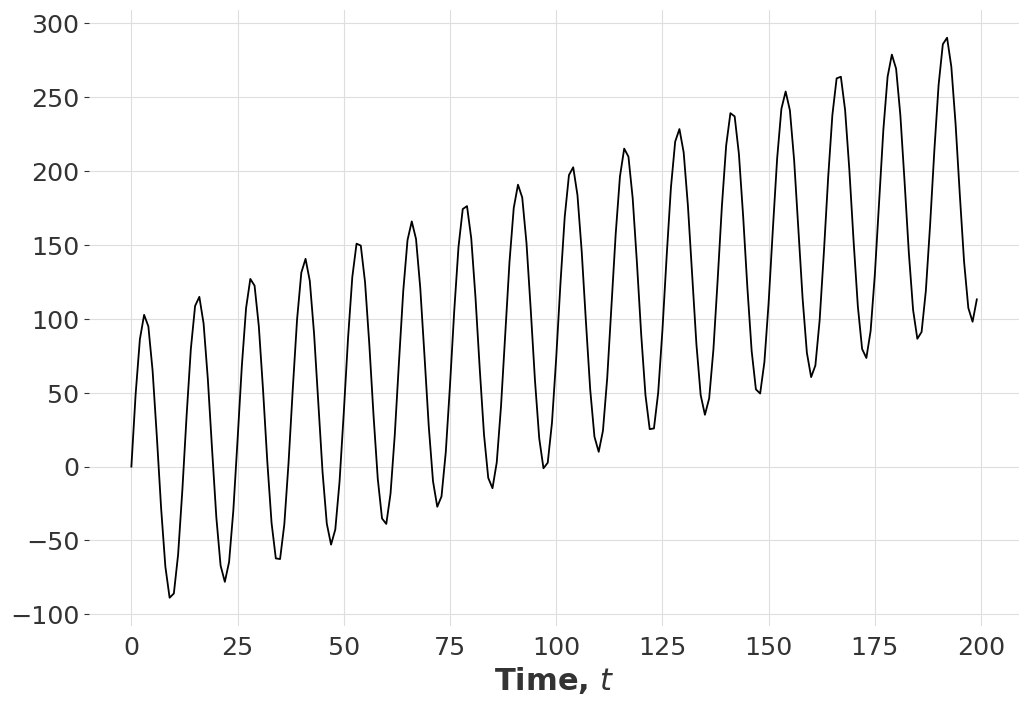

In [24]:
rising_sin_ts = 100 * np.sin(np.arange(0, 100, .5)) + linear_ts
plot_ts(rising_sin_ts)

We can use the seasonal_decompose function from statsmodels, however this model requires a period to be defined by the user. We can estimate this easily using the ACF though (alternatively you can also try to determine this directly via the time series))!

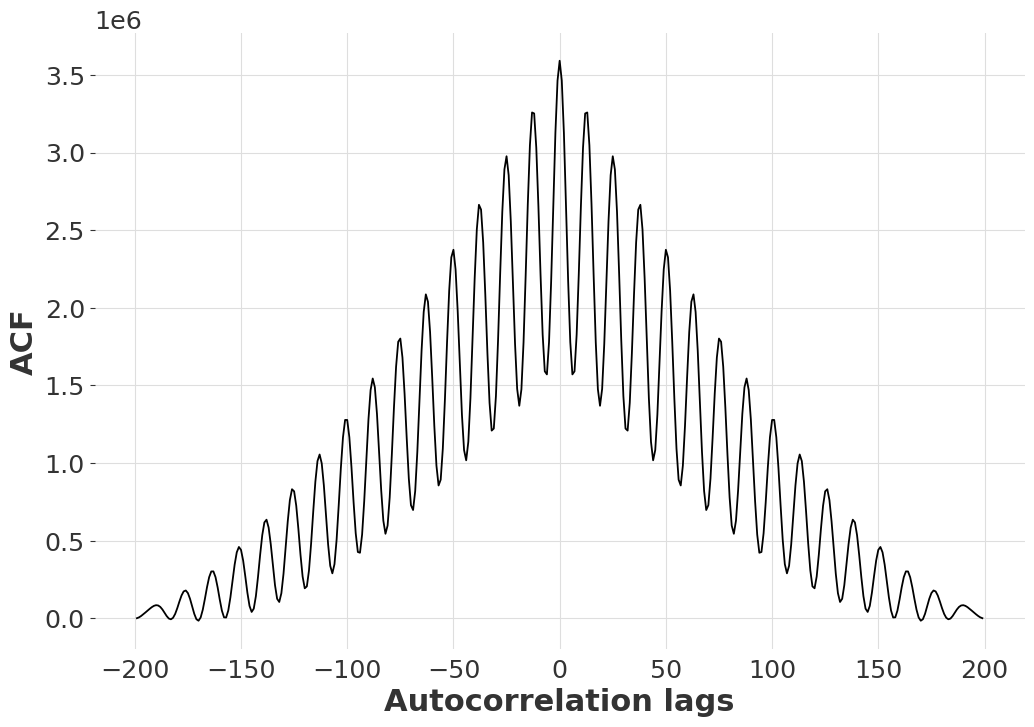

7.6438561897747235


In [25]:
plot_ACF(np.correlate(rising_sin_ts, rising_sin_ts, mode='full'))
labels = rising_sin_ts
print (entropy4(labels))

The period seems to be around 12 or 13, which we use in the next cell (estimated by counting the lags between subsequent peaks in the ACF plot).

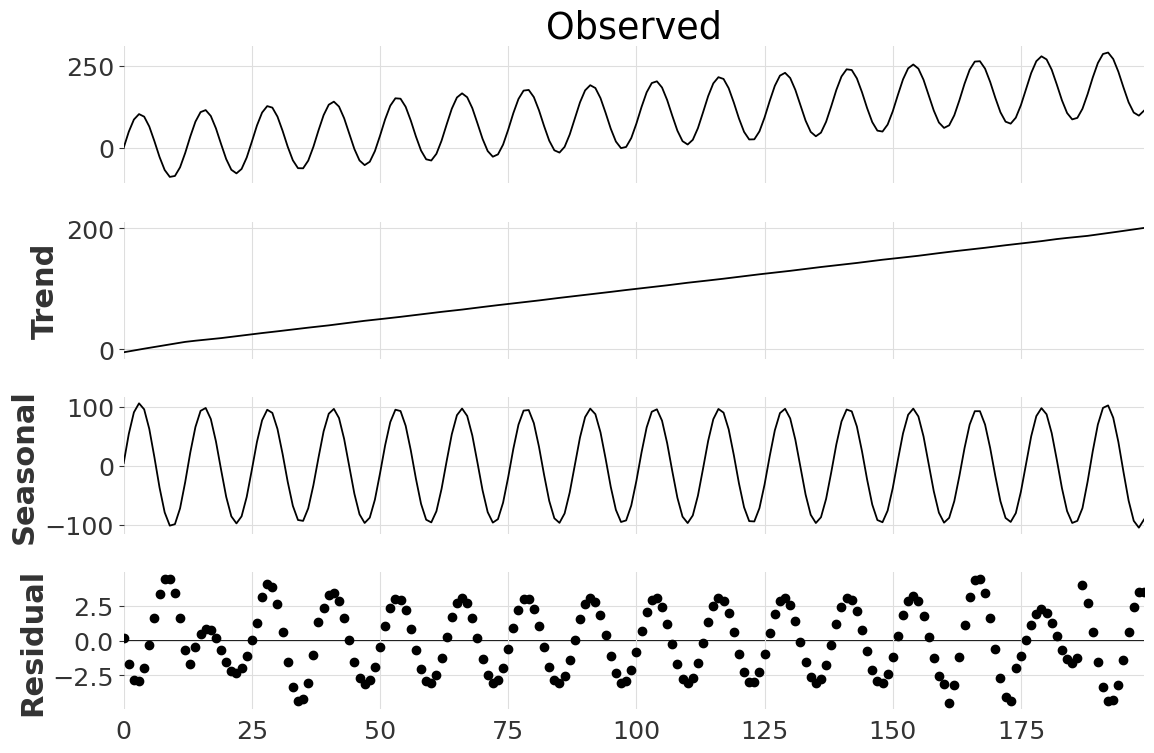

In [26]:
result = STL(rising_sin_ts, period=13).fit()
_ = result.plot()

And, just like magic, we have retrieved the seasonal and trend components (along with some residuals popping up due to estimation errors). Note the difference scale in the trend, seasonal and residual time series.

#### Creating scatter plots

In addition to looking at the ACF and the decomposition, we can also look at the scatter plot of the time series with its one-step lag. We do this here for both the linearly rising time series (linear_ts) and the noise time series (noise_ts).

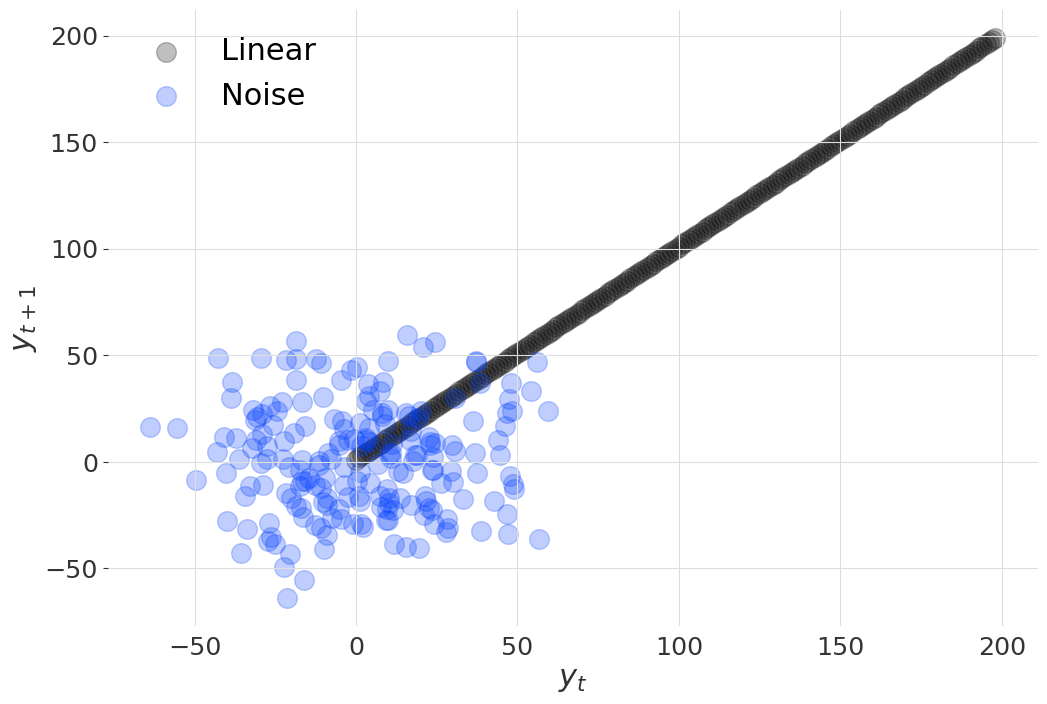

In [27]:
plt.scatter(linear_ts[0:-1], linear_ts[1:], s=200, alpha=.25, label='Linear')
plt.scatter(noise_ts[0:-1], noise_ts[1:], s=200, alpha=.25, label='Noise')
plt.xlabel('$y_t$')
plt.ylabel('$y_{t+1}$')
plt.grid(True)
plt.legend()
plt.show()

There is an obvious relationship between the linear time series lagged by one time-step and its future values, as you would expect. On the other hand, the noise time series has almost no relationship with its lagged values from one time step ago, i.e. the value of the signal at time step $n$ has no predictive power for the value at time step $n+1$. This information is extremely useful when we build our prediction models.

#### Exercises
1. Why does the autocorrelation function taper off? 
2. How does the autocorrelation function and decomposition of an infinitely long noise signal look like?
3. Statsmodels includes more than one decomposition algorithms. Do you understand the difference between these?

### Understanding the influence of exogenous variables
In addition to the autoregressive component in a signal, exogenous variables frequently influence the trajectory of a time series. This is particularly the case for energy data which is, in large part, dependent on user behaviour and ambient conditions. Renewable energy sources, such as solar and wind, for instance, largely rely on weather conditions. Electricity demand, likewise, varies strongly with user behaviour, ambient conditions and even calendar events (weekend vs. weekday, public holiday or not). 

As before, we analyze this on a simulated dataset to get the general idea. Here, we create two linearly increasing datasets. However, we corrupt one of them with some additive Gaussian noise. Such a relationship between two variables is commonly seen in many cases in energy. For instance, in many cases energy demand rises sharply with rising and/or falling ambient temperature (to cope with increasing cooling or heating demand respectively).

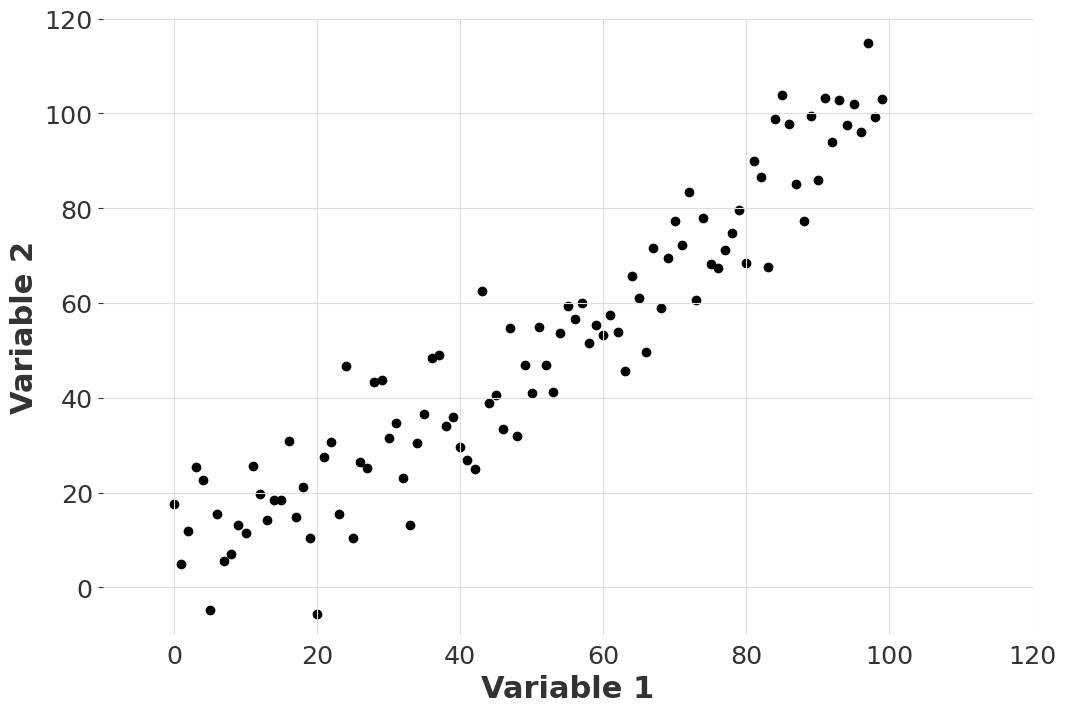

In [28]:
np.random.seed(0)

signal1 = np.arange(100)
signal2 = np.arange(100) + np.random.normal(0,10,100)

plt.scatter(signal1,signal2)
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.grid(True)
plt.xlim(-10, 120)
plt.ylim(-10, 120)
plt.show()

It seems that, despite the noise we introduced, there remains a substantial correlation between the two time series. As one variable increases, so does the other. One way to quantify this relationship is with the [Pearson's correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). 

In [29]:
np.corrcoef(signal1, signal2)

array([[1.        , 0.94129622],
       [0.94129622, 1.        ]])

The Pearson's correlation coefficient can theoretically take a value between -1 and +1, with -1 showing perfectly anti-correlated signals, +1 showing perfectly correlated signals and 0 showing no relationship between the two. A strong positive correlation implies that as the value of one signal increases, the other variable's value also increases. 

The correlation coefficient in this case is quite high at 0.94, which shows a very strong tendency for the two signals to move in tandem. This is hardly surprising, as they were both derived from the same linearly rising signal.

Note that correlation does not imply causation, and even though we use correlations to predict the future, it is an inexact science. Not convinced? Take a look [here](https://tylervigen.com/page?page=1) to understand spurious correlations such as how Nicholas Cage appearing in movies has a pretty high correlation with people drowning in pools.

Next, let's see how correlation works where the input and output variables have a more complex, non-linear relationship.

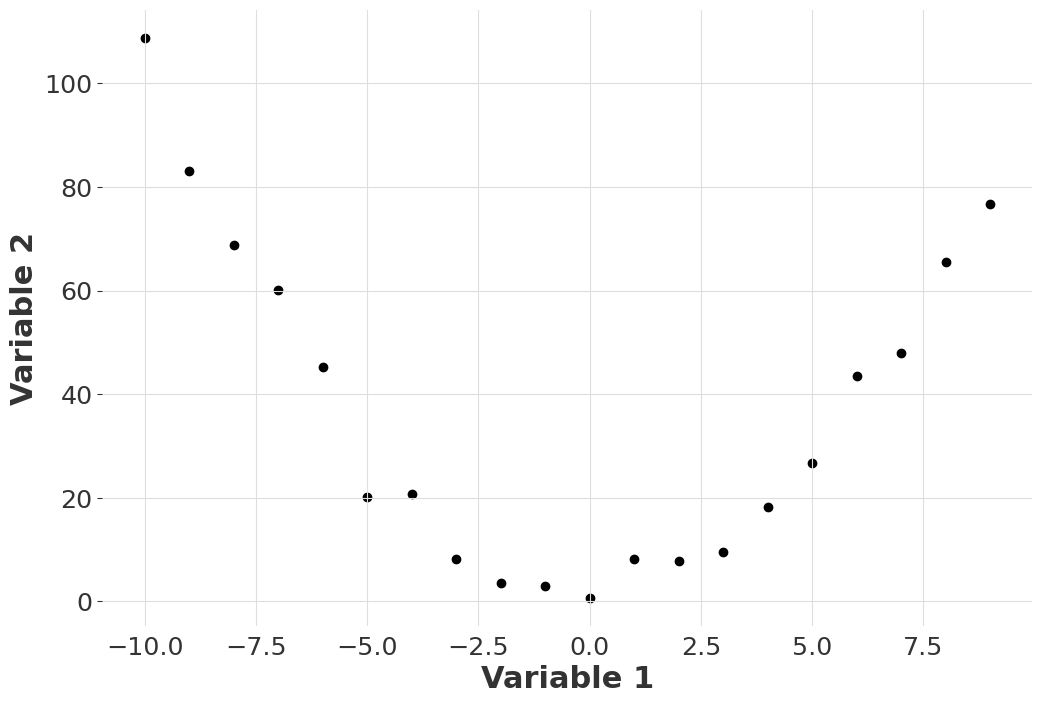

In [30]:
np.random.seed(0)

signal1 = np.arange(-10, 10) 
signal2 = np.arange(-10, 10) ** 2 + np.random.normal(0, 5, 20)

plt.scatter(signal1, signal2)
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.grid(True)
plt.show()

In [31]:
np.corrcoef(signal1, signal2)

array([[ 1.        , -0.24115522],
       [-0.24115522,  1.        ]])

So, even though the two variables are clearly linked quadratically, the correlation coefficient comes out very low. This is because the Pearson's correlation coefficient is only valid for linear relationships as you can see here. For nonlinear relationships, Spearman's rank or Kendall's Tau coefficients can be used instead (under certain conditions).

#### Exercises
1. What happens to the correlation coefficient as you increase the Gaussian noise strength?
2. Fit a line (linear function) to the two plots we have created in this section using [this library](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html)
3. Fit higher order functions (2 to 20) to the datasets using the same library (by changing the polynomial degree in the arguments). Explain what happens as you increase the order of the polynomial. Pay particular attention to regions where you have few data points and when you are extrapolating (i.e. predicting points beyond what was observed).

## Application to Belgian electricity demand

Let's extend what we have seen in this lecture so far by applying it to the electricity demand in Belgium. First let's load this dataset.

In [8]:
data = pd.read_parquet('data_load_forecasts_fixed.parquet')
data

,Load,Temperature,Forecast
time,,,
2018-01-01 00:00:00,8143.500000,3.50,9013.750000
2018-01-01 01:00:00,7789.000000,3.74,8719.750000
2018-01-01 02:00:00,7470.750000,2.57,8474.750000
2018-01-01 03:00:00,7354.500000,1.96,8306.666667
2018-01-01 04:00:00,7374.250000,1.44,8234.000000
...,...,...,...
2020-01-01 19:00:00,9021.000000,0.19,8866.333333
2020-01-01 20:00:00,8912.250000,0.62,8750.500000
2020-01-01 21:00:00,9148.666667,-2.91,8981.500000


The dataframe $data$ we just loaded contains several fields. This includes the _time of observation, actual observed_ and _predicted load on the Belgian grid,_ and _the temperature._
However, for now, we focus only on the time field (i.e. the index of the dataframe) and the Load field (which is the observed energy demand).

<Axes: xlabel='time'>

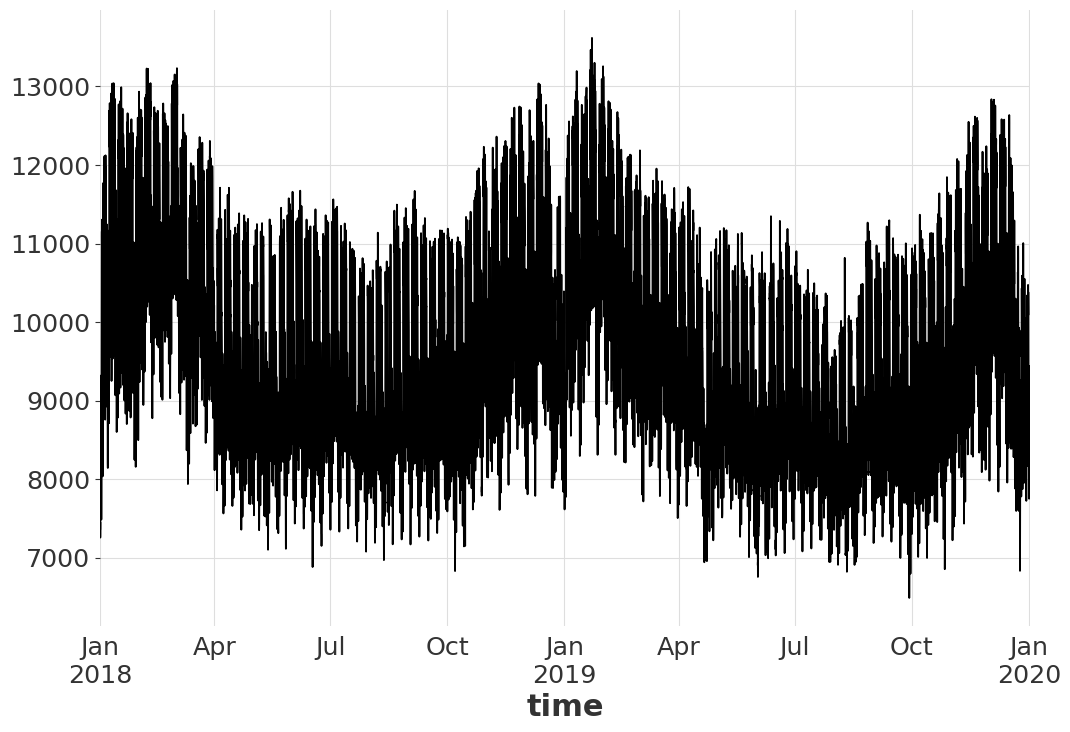

In [9]:
data.Load.plot()

There seems to be an obvious seasonality in the data, with higher energy demand during the winter as compared to the summer. We can use tools we learned earlier in this session to understand this better. Recall the STL decomposition. As a first step, we need to estimate the periodicity in our data. Let's take a look at the ACF plot.

In [ ]:
# TODO: Visualize the ACF of the data.load variable (for varying lags)

Here you should encounter a curious problem. Previously we defined the seasonal period in our time series. Now, however, we have a different challenge. Our load time series demonstrates multiple seasonalities: daily, and weekly as visualized here, and yearly if you increase the number of lags. While there are techniques to handle this multi-seasonal effect, this is well beyond the scope of this preliminary tutorial. For now let's plot the decomposition with the weekly periodicity (a week contains 168 hours, which is what we use for our period here - since we have hourly sampled data).

In [ ]:
# TODO: Use STL to decompose the data.Load time series with a period of 24 or 168.

You will have noticed that we also have the temperature in Leuven, Belgium as part of the dataframe. Let's see how temperature affects electricity demand. 

In [ ]:
# TODO: Estimate the correlation between the electricity demand and temperature data

In [ ]:
# TODO: Plot the electricity demand as a function of the temperature to see if you can spot the relationship

### Exercises
1. Which seasonality better explain the data: 24 or 168? How can you tell?
2. What lessons can you draw from the trend and seasonal plots? Also, can you explain the dip around new year in the trend plot, especially when using a value of 168 for period?
3. Do you have an intuition for the high (recurring) values in the residuals plot?
4. Does temperature influence electricity demand? Does this match your intuition?

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5e07dece-2140-4897-ae8d-a013df5eb392' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>